Мы рассмотрели два варианта представления трейсов: TF-IDF по последовательности событий и агрегированные числовые признаки. В качестве финального подхода для детекции аномалий использовалась модель Isolation Forest, обученная на агрегированных признаках.

### Подготовка к IF

In [39]:
import pandas as pd
import re

# 1. Загружаем parquet
df = pd.read_parquet("hdfs_logs.parquet")
print(df.shape)
display(df.head())

# 2. Берем только строки, где есть BlockId
df_seq = df.dropna(subset=["BlockId"]).copy()
df_seq["BlockId"] = df_seq["BlockId"].astype(str)

# 3. timestamp в нужном типе и сортируем по (BlockId, timestamp)
if not pd.api.types.is_datetime64_any_dtype(df_seq["timestamp"]):
    df_seq["timestamp"] = pd.to_datetime(df_seq["timestamp"], errors="coerce")

df_seq = df_seq.sort_values(["BlockId", "timestamp"], kind="mergesort")

print("Строк с BlockId:", len(df_seq))
display(df_seq.head())


IP_RE      = re.compile(r"\b\d{1,3}(?:\.\d{1,3}){3}\b")
HEX_RE     = re.compile(r"\b[0-9a-fA-F]{6,}\b")
PATH_RE    = re.compile(r"(?:/[^ \t\n\r\f\v]+)+")
NUM_RE     = re.compile(r"\b\d+\b")
BLK_RE     = re.compile(r"\bblk_[\-\d]+\b")

def normalize_msg(s: str) -> str:
    s = s.lower()
    s = BLK_RE.sub(" <blk> ", s)
    s = IP_RE.sub(" <ip> ", s)
    s = PATH_RE.sub(" <path> ", s)
    s = HEX_RE.sub(" <hex> ", s)
    s = NUM_RE.sub(" <num> ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 5. Строим один «токен события» из level + component + нормализованного текста
def row_to_token(row) -> str:
    msg = normalize_msg(str(row["message"]))
    comp = str(row.get("component", "")).split("$")[0].lower() if pd.notna(row.get("component")) else ""
    level = str(row.get("level", "")).lower() if pd.notna(row.get("level")) else ""
    return f"{comp}_{level}__ {msg}"

# 6. Создаем колонку event_token 
df_seq["event_token"] = df_seq.apply(row_to_token, axis=1)

print(df_seq.columns)
display(df_seq[["timestamp", "BlockId", "level", "component", "event_token"]].head())

# 7. Группируем по BlockId и собираем последовательность токенов
df_blocks = (
    df_seq.groupby("BlockId")["event_token"]
          .apply(lambda x: " . ".join(x))   
          .reset_index(name="tokenized_block")
)

print("Количество блоков:", len(df_blocks))
display(df_blocks.head())

(11175629, 6)


,timestamp,level,component,message,BlockId,pid
0,2008-11-09 20:35:18,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
1,2008-11-09 20:35:18,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,blk_-1608999687919862906,35
2,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
3,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,145
4,2008-11-09 20:35:19,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,blk_-1608999687919862906,145


Строк с BlockId: 11175629


,timestamp,level,component,message,BlockId,pid
10365303,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1000002529962039464 src: ...,blk_-1000002529962039464,25370
10365350,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1000002529962039464 src: ...,blk_-1000002529962039464,25851
10365359,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1000002529962039464 src: ...,blk_-1000002529962039464,25867
10365421,2008-11-11 09:44:52,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /user/root/ra...,blk_-1000002529962039464,30
10365597,2008-11-11 09:44:54,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-1000002529962...,blk_-1000002529962039464,25852


Index(['timestamp', 'level', 'component', 'message', 'BlockId', 'pid',
       'event_token'],
      dtype='object')


,timestamp,BlockId,level,component,event_token
10365303,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.DataNode$DataXceiver,dfs.datanode_info__ receiving block <blk> src:...
10365350,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.DataNode$DataXceiver,dfs.datanode_info__ receiving block <blk> src:...
10365359,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.DataNode$DataXceiver,dfs.datanode_info__ receiving block <blk> src:...
10365421,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.FSNamesystem,dfs.fsnamesystem_info__ block* namesystem.allo...
10365597,2008-11-11 09:44:54,blk_-1000002529962039464,INFO,dfs.DataNode$PacketResponder,dfs.datanode_info__ packetresponder <num> for ...


Количество блоков: 575061


,BlockId,tokenized_block
0,blk_-1000002529962039464,dfs.datanode_info__ receiving block <blk> src:...
1,blk_-100000266894974466,dfs.fsnamesystem_info__ block* namesystem.allo...
2,blk_-1000007292892887521,dfs.datanode_info__ receiving block <blk> src:...
3,blk_-1000014584150379967,dfs.datanode_info__ receiving block <blk> src:...
4,blk_-1000028658773048709,dfs.datanode_info__ receiving block <blk> src:...


## TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.95,
    token_pattern=r"(?u)\b\w+\b",
)

X = vectorizer.fit_transform(df_blocks["tokenized_block"])
print("TF-IDF:", X.shape)

TF-IDF: (575061, 311)


## Isolation Forest

| Гиперпараметр | Что делает | Значение |
|----------|--------------|------------|
| n_estimators | Количество деревьев в лесу |   100|
| max_samples | Количество случайных выборок для каждого дерева |100_000|
| contamination |Ожидаемая доля аномалий| auto|

```
Ключевая идея Isolation Forest заключается в случайной изоляции наблюдений: алгоритм порождает несколько случайных решающих деревьев (так называемые iTrees), которые рекурсивно делят пространство признаков, стремясь отделить каждую точку данных. Аномальные точки, будучи «редкими» и существенно отличающимися от большинства, как правило, изолируются быстрее, то есть оказываются на меньшей глубине дерева. Таким образом, совокупная средняя длина пути до изоляции объекта служит индикатором его нормальности: у аномалий путь короче (они изолируются за меньшее число разбиений), чем у нормальных объектов.

Для применения Isolation Forest к данным логов необходимо представить последовательности событий в виде фиксированного набора признаков. В рамках данного исследования каждая последовательность логов (соответствующая одному BlockId) была преобразована в текстовую строку, состоящую из нормализованных токенов событий. Нормализация включала удаление переменных элементов сообщений (IP-адресов, чисел, путей, хешей и т. д.), что позволило привести сообщения к устойчивому виду. Затем для каждого блока строился вектор признаков методом TF–IDF, где токенами выступали нормализованные события (event_token). Полученная TF–IDF матрица размерностью (N × m), где N — число блоков, m — количество различных токенов, использовалась как вход для модели Isolation Forest.

Isolation Forest обучен на 80% нормальных блоков. 

Порог по isolation score подбирался по валидационной выборке по максимальному значению F1-меры. Перебирались 300 квантилей значений if_score, для каждого порога вычислялись метрики качества (Precision, Recall, F1, FPR).

Оптимальный порог составил ≈0.0599, при котором были получены следующие значения:
	•	Precision ≈ 0.84 – около 84% помеченных моделью блоков действительно являются аномальными;
	•	Recall ≈ 0.82 – модель обнаруживает примерно 82% всех аномалий;
	•	F1 ≈ 0.83 – хороший баланс между точностью и полнотой;
	•	FPR ≈ 0.0046 – лишь 0.46% нормальных блоков ошибочно классифицируются как аномальные.

Таким образом, Isolation Forest на TF–IDF-представлении логов формирует адекватный профиль «нормального» поведения системы и позволяет с высокой точностью и достаточно высокой полнотой выявлять аномальные последовательности логов при низкой доле ложных срабатываний.
```

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split

labels = pd.read_csv("anomaly_label.csv")
labels.rename(columns={"block_id": "BlockId", "blockid": "BlockId"}, inplace=True)
labels["BlockId"] = labels["BlockId"].astype(str)

df_labeled = df_blocks.merge(labels, on="BlockId", how="inner")

df_labeled["true_label"] = (df_labeled["Label"] == "Anomaly").astype(int)

df_blocks = df_blocks.reset_index(drop=True)
df_blocks["block_idx"] = np.arange(len(df_blocks))

df_labeled = df_labeled.merge(
    df_blocks[["BlockId", "block_idx"]],
    on="BlockId",
    how="left"
)

y_all = df_labeled["true_label"].to_numpy()
block_idx_all = df_labeled["block_idx"].to_numpy()

normal_idx = np.where(y_all == 0)[0]
anom_idx   = np.where(y_all == 1)[0]

train_norm_idx, val_norm_idx = train_test_split(
    normal_idx, test_size=0.2, random_state=42
)

train_idx = train_norm_idx
val_idx   = np.concatenate([val_norm_idx, anom_idx])

X_train = X[block_idx_all[train_idx]]
X_val   = X[block_idx_all[val_idx]]
y_val   = y_all[val_idx]

In [42]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,
    max_samples=min(100_000, X_train.shape[0]),
    contamination="auto",
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

iso.fit(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished


IsolationForest(max_samples=100000, n_jobs=-1, random_state=42, verbose=1)

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

scores = df_eval["if_score"].values
y_true = df_eval["true_label"].values.astype(int)

thr_list = np.linspace(scores.min(), scores.max(), 300)

history = []

for thr in thr_list:
    # аномалия, если if_score <= threshold (чем меньше score, тем "страннее")
    y_pred = (scores <= thr).astype(int)

    # чтобы не падало, если нет ни одной предсказанной аномалии
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)

    history.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fpr": fpr,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
    })

metrics_df = pd.DataFrame(history)
metrics_df_sorted = metrics_df.sort_values("f1", ascending=False)

print("ТОП-10 порогов по F1:")
display(metrics_df_sorted.head(10))

ТОП-10 порогов по F1:


,threshold,precision,recall,f1,fpr,tp,fp,fn,tn
230,0.059909,0.844212,0.824207,0.834090,0.004588,13878,2561,2960,555662
229,0.058265,0.867557,0.756266,0.808097,0.003482,12734,1944,4104,556279
231,0.061552,0.787047,0.824207,0.805199,0.006727,13878,3755,2960,554468
232,0.063196,0.742099,0.824207,0.781001,0.008640,13878,4823,2960,553400
233,0.064840,0.741980,0.824207,0.780935,0.008645,13878,4826,2960,553397
234,0.066484,0.737603,0.824207,0.778504,0.008844,13878,4937,2960,553286
235,0.068128,0.685827,0.824801,0.748921,0.011397,13888,6362,2950,551861
236,0.069772,0.676441,0.824801,0.743290,0.011900,13888,6643,2950,551580
237,0.071416,0.668592,0.824801,0.738527,0.012332,13888,6884,2950,551339
238,0.073059,0.668046,0.824801,0.738193,0.012362,13888,6901,2950,551322


In [44]:
best_row = metrics_df_sorted.iloc[0]
best_thr = best_row["threshold"]

print("Лучший порог по F1:", best_thr)
print(f"Precision={best_row['precision']:.4f}, Recall={best_row['recall']:.4f}, F1={best_row['f1']:.4f}, FPR={best_row['fpr']:.4f}")

# финальные предсказания с этим порогом
df_eval["is_anomaly_if"] = (scores <= best_thr).astype(int)

Лучший порог по F1: 0.05990850867957964
Precision=0.8442, Recall=0.8242, F1=0.8341, FPR=0.0046


## Метрики качества

```
Интерпретация: 
Precision = 0.8442. Означает, что 84% найденных моделью аномалий действительно являются аномалиями.
Recall = 0.8242. Означает, что модель нашла около 82% всех существующих аномалий.
F1-score (гармоническое среднее точности и полноты) = 0.8341. Означает, что Isolation Forest хорошо определяет выявленные аномалии (precision = 0.8442), при этом модель не пропускает значительную их часть (0.8242). Таким образом, модель хорошо минимизирует количество ложных аномалий и с высокой точностью распознает наиболее выраженные аномалии, а также обеспечивает высокое покрытие аномалий.
FPR = 0.0046. Только 0.46% нормальных блоков модель ошибочно пометила как аномалии.
```


### Гистрограмма

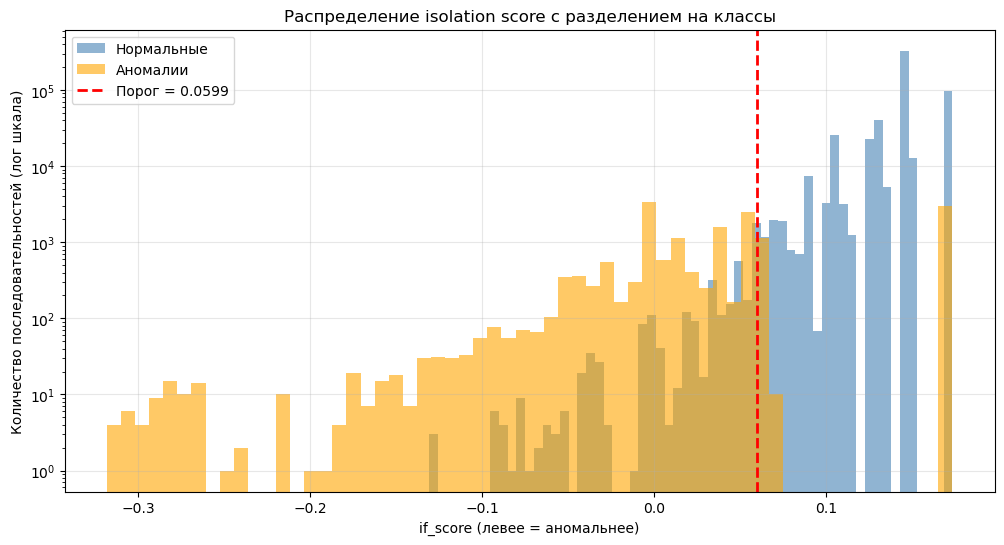

In [45]:
import matplotlib.pyplot as plt
import numpy as np

scores = df_eval["if_score"]
labels = df_eval["true_label"]  # 1 = anomaly, 0 = normal

plt.figure(figsize=(12, 6))

# нормальные
plt.hist(scores[labels == 0], bins=60, alpha=0.6,
         label="Нормальные", color="steelblue")

# аномалии
plt.hist(scores[labels == 1], bins=60, alpha=0.6,
         label="Аномалии", color="orange")

# порог
plt.axvline(best_thr, color="red", linestyle="--", linewidth=2,
            label=f"Порог = {best_thr:.4f}")

plt.yscale("log")  # логарифмическая шкала
plt.xlabel("if_score (левее = аномальнее)")
plt.ylabel("Количество последовательностей (лог шкала)")
plt.title("Распределение isolation score с разделением на классы")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

На гистограмме isolation score заметно, что нормальные последовательности (синие) имеют в основном положительные значения score и формируют плотный пик справа. Аномалии (оранжевые) сконцентрированы в области отрицательных и малых положительных значений, образуя “хвост” распределения слева.

Выбранный порог 0.0599 хорошо разделяет две группы, что подтверждается высокими значениями precision = 0.844 и recall = 0.824. Логарифмическая шкала по оси Y позволяет визуализировать редкие аномальные последовательности на фоне значительно более частых нормальных.

# Isolation Forest по агрегированным признакам трейсов


In [3]:
import pandas as pd
feat = pd.read_parquet("/Users/slvic/PycharmProjects/copies/22-team-project/features_by_block.parquet")

labels = pd.read_csv("/Users/slvic/Downloads/HDFS_v1/preprocessed/anomaly_label.csv")
labels.rename(columns={"block_id":"BlockId","blockid":"BlockId"}, inplace=True)
labels["BlockId"] = labels["BlockId"].astype(str)
feat["BlockId"] = feat["BlockId"].astype(str)

df_l = feat.merge(labels, on="BlockId", how="inner")
df_l["true_label"] = (
    df_l["Label"].astype(str).str.lower().isin(["anomaly","fail"])
).astype(int)

num_cols = [c for c in df_l.columns if c not in ["BlockId","Label","true_label"]]
X = df_l[num_cols].fillna(0).to_numpy()
y = df_l["true_label"].to_numpy()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np

normal_idx = np.where(y == 0)[0]
anom_idx   = np.where(y == 1)[0]

train_norm_idx, val_norm_idx = train_test_split(
    normal_idx, test_size=0.2, random_state=42
)

train_idx = train_norm_idx
val_idx   = np.concatenate([val_norm_idx, anom_idx])

X_train = X[train_idx]
X_val   = X[val_idx]
y_val   = y[val_idx]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

iso = IsolationForest(
    n_estimators=200,
    max_samples=min(100_000, X_train_s.shape[0]),
    random_state=42,
    n_jobs=-1,
    contamination="auto",
)
iso.fit(X_train_s)

scores = iso.decision_function(X_val_s)

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

scores_arr = np.asarray(scores)
y_true = np.asarray(y_val).astype(int)

# диапазон порогов
thr_list = np.linspace(scores_arr.min(), scores_arr.max(), 300)

rows = []

for thr in thr_list:
    # anomaly, если score <= threshold
    y_pred = (scores_arr <= thr).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fpr": fpr,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
    })

metrics_df = pd.DataFrame(rows)
metrics_df_sorted = metrics_df.sort_values("f1", ascending=False)

print("ТОП-10 threshold по F1:")
display(metrics_df_sorted.head(10))

ТОП-10 threshold по F1:


,threshold,precision,recall,f1,fpr,tp,fp,fn,tn
185,-0.044553,0.951128,0.994002,0.972092,0.007703,16737,860,101,110785
186,-0.042896,0.948925,0.996377,0.972073,0.008088,16777,903,61,110742
184,-0.046211,0.953071,0.991448,0.971881,0.007363,16694,822,144,110823
183,-0.047869,0.955080,0.988716,0.971607,0.007013,16648,783,190,110862
187,-0.041238,0.946630,0.997565,0.971430,0.008482,16797,947,41,110698
182,-0.049526,0.957659,0.984618,0.970952,0.006565,16579,733,259,110912
188,-0.039581,0.943481,0.998337,0.970134,0.009020,16810,1007,28,110638
181,-0.051184,0.959021,0.979867,0.969332,0.006315,16499,705,339,110940
189,-0.037923,0.941279,0.998634,0.969108,0.009396,16815,1049,23,110596
190,-0.036265,0.938400,0.998812,0.967664,0.009888,16818,1104,20,110541


In [6]:
best = metrics_df_sorted.iloc[0]
best_thr = best["threshold"]

print("Лучший threshold:", best_thr)
print(
    f"Precision={best['precision']:.4f}, "
    f"Recall={best['recall']:.4f}, "
    f"F1={best['f1']:.4f}, "
    f"FPR={best['fpr']:.4f}"
)

# финальные предсказания
y_pred_best = (scores_arr <= best_thr).astype(int)

Лучший threshold: -0.044553359609683596
Precision=0.9511, Recall=0.9940, F1=0.9721, FPR=0.0077


In [7]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_best).ravel()

print("Confusion matrix:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Confusion matrix:
TN=110785, FP=860, FN=101, TP=16737


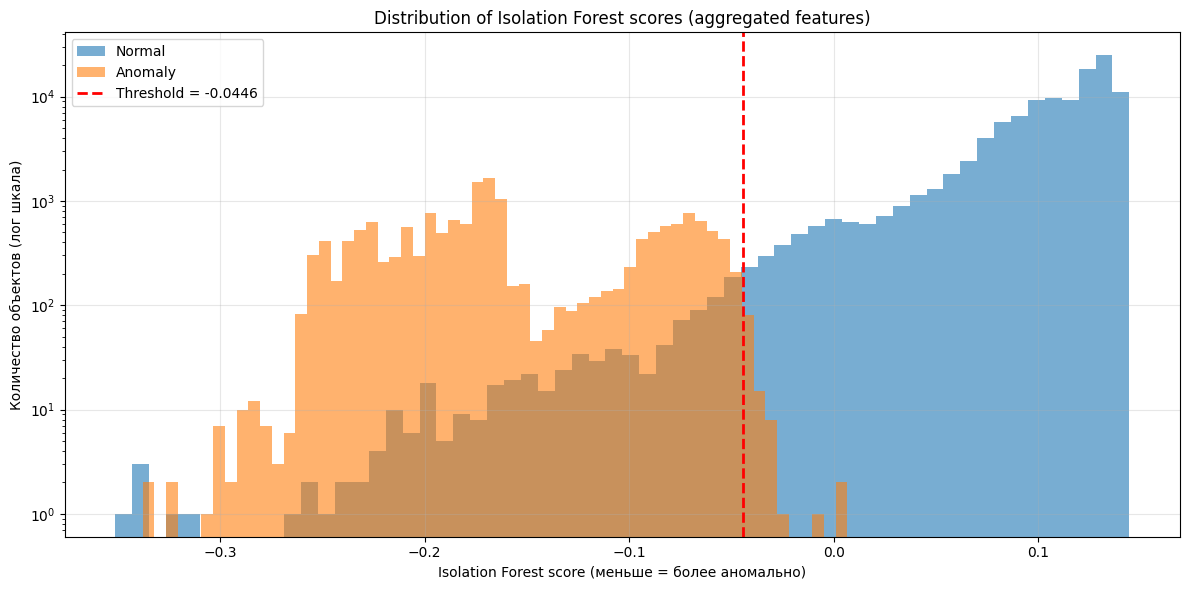

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# нормальные
plt.hist(
    scores_arr[y_true == 0],
    bins=60,
    alpha=0.6,
    label="Normal",
)

# аномальные
plt.hist(
    scores_arr[y_true == 1],
    bins=60,
    alpha=0.6,
    label="Anomaly",
)

# порог
plt.axvline(
    best_thr,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Threshold = {best_thr:.4f}"
)

plt.yscale("log")
plt.xlabel("Isolation Forest score (меньше = более аномально)")
plt.ylabel("Количество объектов (лог шкала)")
plt.title("Distribution of Isolation Forest scores (aggregated features)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Модель Isolation Forest, обученная на агрегированных признаках трейсов, демонстрирует высокую эффективность детекции аномалий. Получено значение F1-меры около 0.97 при уровне ложноположительных срабатываний менее 1%, что свидетельствует о хорошей разделимости нормальных и аномальных трейсов в пространстве агрегированных признаков.

In [9]:
df_eval = pd.DataFrame({
    "if_score": scores_arr,
    "true_label": y_true,
    "is_anomaly_if": y_pred_best
})

display(df_eval.head())

,if_score,true_label,is_anomaly_if
0,0.130212,0,0
1,0.100326,0,0
2,0.124763,0,0
3,0.087960,0,0
4,0.136947,0,0


Сравнение двух вариантов модели Isolation Forest показало, что использование агрегированных числовых признаков трейсов существенно превосходит текстовое представление на основе TF-IDF. Модель, обученная на агрегированных признаках, достигла значения F1-меры около 0.97 при высокой полноте и низком уровне ложноположительных срабатываний, тогда как вариант на TF-IDF-признаках продемонстрировал заметно более низкое качество (F1 ≈ 0.83) и существенное перекрытие распределений нормальных и аномальных трейсов. Это подтверждает, что для задач детекции аномалий в распределённых системах более информативными являются признаки, отражающие поведение трейсов, а не лексическое содержание лог-сообщений.